In [1]:
# Run this if you can't import AlphaOpt
# Alternatively, use os.chdir('[AlphaOpt_directory]')
import os
#..\AlphaOpt\experiments\template
print(os.getcwd())
#..\AlphaOpt\experiments
%cd ".."
#..\AlphaOpt
%cd ".."

/Users/davisgay/github/AlphaOpt/experiments/svm
/Users/davisgay/github/AlphaOpt/experiments
/Users/davisgay/github/AlphaOpt


In [2]:
import os
print(os.getcwd())
%pylab inline
import GPyOpt
import GPy
from AlphaOpt import components
from AlphaOpt.components import CustomCostModel as CostModel
import time

/Users/davisgay/github/AlphaOpt
Populating the interactive namespace from numpy and matplotlib


In [63]:
from sklearn import svm, preprocessing, metrics
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original', data_home=os.path.join(os.getcwd(), "data"))



X, y = mnist.data, mnist.target


# Randomly split into 1% train (700) while keeping class balance.
# Feature vector length 784

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.99, random_state=0)
for train_index, test_index in sss.split(X, y):
    X_train = X[train_index]
    y_train = y[train_index]
    print("X_train size: %s, %s" % (X_train.shape))
    print("Y_train size: %s" % (y_train.shape))


# It is usually a good idea to scale the data for SVM training.
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)

nfold = 5

# Objective: Jaccard Similarity
def fit_svc_val(x):
    x = np.atleast_2d(np.exp(x))
    fs = np.zeros((x.shape[0],1))
    for i in range(x.shape[0]):
        fs[i] = 0
        for n in range(nfold):
            idx = np.array(range(X_train.shape[0]))
            idx_valid = np.logical_and(idx>=X_train.shape[0]/nfold*n, idx<X_train.shape[0]/nfold*(n+1))
            idx_train = np.logical_not(idx_valid)
            svc = svm.SVC(C=x[i,0],gamma=x[i,1])
            svc.fit(X_train[idx_train],y_train[idx_train])
            # SVC.score defaults to sklearn.metrics.accuracy_score which defaults to 
            # sklearn.metrics.jaccard_similarity_score for multiclass model
            
            # fraction of misclassifications (float)
            fs[i] += metrics.zero_one_loss(y_train[idx_valid], svc.predict(X_train[idx_valid]))
        fs[i] *= 1./nfold
    return fs


X_train size: 700, 784
Y_train size: 700


We set search interval of C to be roughly [0.001, 60,000], gamma to be roughly [1x10^-5, 8]

In [64]:
# Sample Experiment
objective = GPyOpt.core.task.SingleObjective(fit_svc_val)
space = GPyOpt.Design_space(space =[{'name': 'C', 'type': 'continuous', 'domain': (-7.,11.)},
                                    {'name': 'gamma', 'type': 'continuous', 'domain': (-12.,2.)}])
X_init = GPyOpt.util.stats.initial_design('random', space, 5)


In [65]:
# Bayesian Optimization Components
# GP models
model = GPyOpt.models.GPModel(kernel=GPy.kern.Matern52(input_dim=2, ARD=True),optimize_restarts=5,verbose=False)
cost = CostModel(GPy.kern.Matern52(input_dim=2, ARD=True), 'evaluation_time')

# Decision models
aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(space)
aquisition = GPyOpt.acquisitions.EI.AcquisitionEI(model, space, aquisition_optimizer)
evaluator = GPyOpt.core.evaluators.Sequential(aquisition)

In [66]:
#Combine everything
bo = GPyOpt.methods.ModularBayesianOptimization(model=model,
                                                space=space,
                                                objective=objective,
                                                acquisition=aquisition,
                                                evaluator=evaluator,
                                                X_init=X_init,
                                                cost=cost)

In [67]:
max_iter  = 20
bo.run_optimization(max_iter = max_iter)
print("Time per iteration: %s" % (bo.cum_time / bo.num_acquisitions))

Time per iteration: 1.6539943099021912


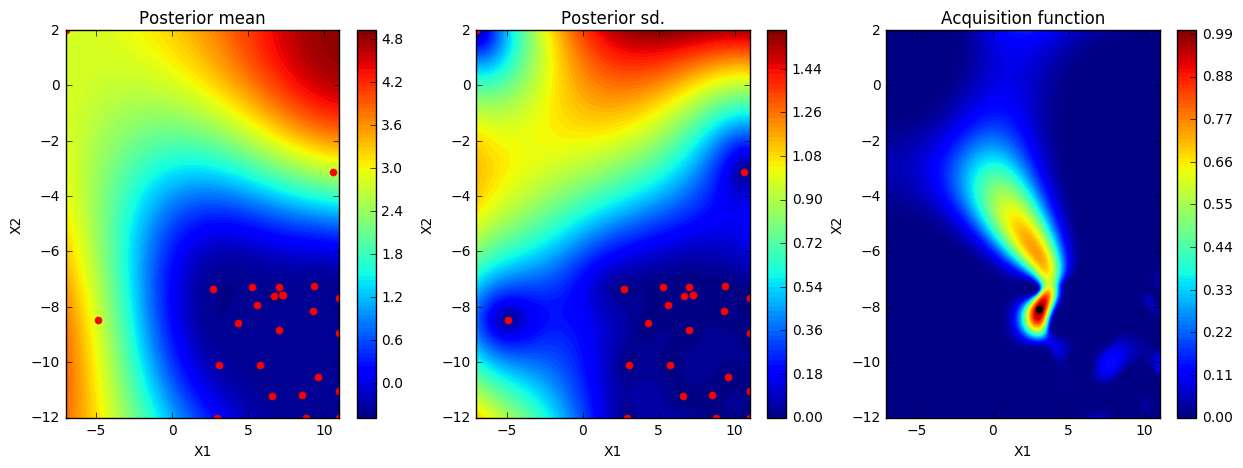

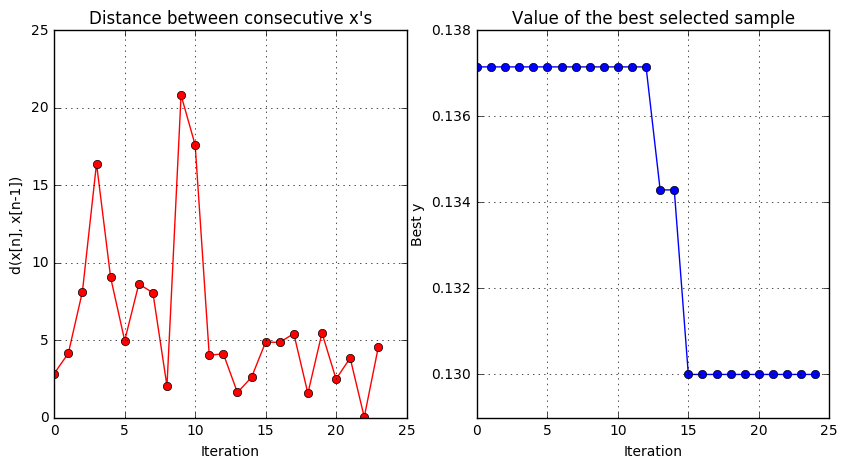

In [68]:
bo.plot_acquisition()
bo.plot_convergence()